# Missiles and Rockets


We are going to try and create a model that can tell the difference between missiles and rockets

In [3]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
# This file contains all the main external libs we'll use
from fastai.imports import *

In [5]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [6]:
PATH = "/home/ubuntu/data/missilesrockets/"
sz=224



In [7]:
os.listdir(PATH)


['tmp', 'valid', 'models', 'train']

In [9]:
os.listdir(f'{PATH}valid')

['rocket', 'missile']

In [10]:
files = os.listdir(f'{PATH}valid/rocket')[:5]
files

['13. picture-of-space-rocket-7.jpg',
 '1. free-picture-of-space-rocket-since-fire-needs-oxygen-to-burn-how-do-rockets-work-in-the-vacuum.jpg',
 '12. 21736195-space-rocket.jpg',
 '10. space-rocket-start-.jpg',
 '6. shutterstock_308948921.jpg']

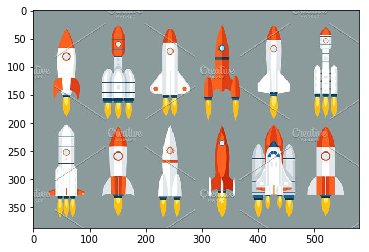

In [11]:
img = plt.imread(f'{PATH}valid/rocket/{files[3]}')
plt.imshow(img)

## Quick Start Model


In [12]:
arch = resnet34
data = ImageClassifierData.from_paths(PATH,tfms=tfms_from_model(arch,sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 2)

A Jupyter Widget

epoch      trn_loss   val_loss   accuracy                
    0      0.873226   0.604957   0.628571  
    1      0.732521   0.383508   0.885714        



[array([ 0.38351]), 0.88571429252624512]

### Lets analyze the pictures

In [18]:
data.val_y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [19]:
data.classes

['missile', 'rocket']

In [21]:
log_preds = learn.predict()
log_preds.shape

(35, 2)

In [22]:
preds = np.argmax(log_preds, axis=1)
probs = np.exp(log_preds[:,1])

In [60]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0],4,replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

In [61]:
def plot_val_with_titleplot_val (idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

In [62]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [63]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

Correctly classified


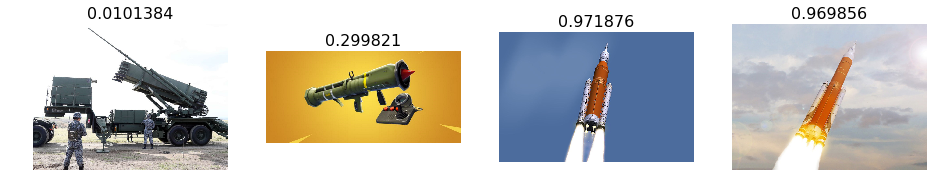

In [58]:
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified")

Incorrectly classified


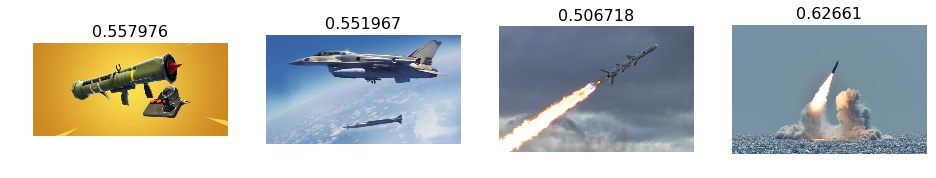

In [51]:
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

In [65]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)


Most correct missiles


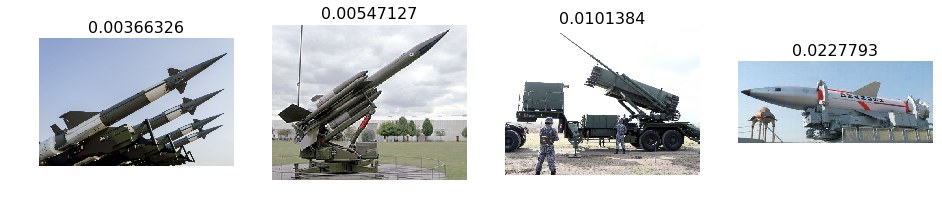

In [66]:
plot_val_with_title(most_by_correct(0, True), "Most correct missiles")

Most correct rockets


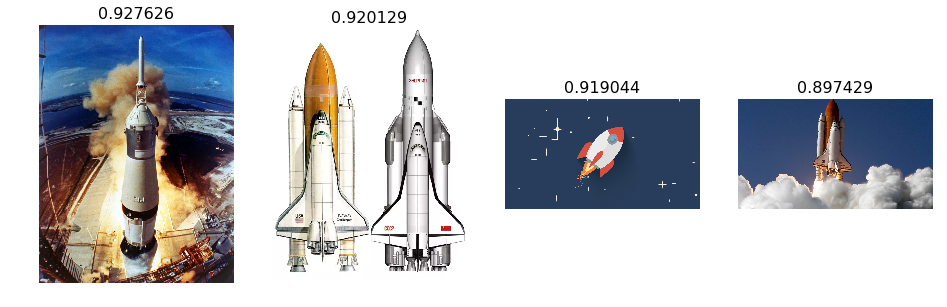

In [55]:
plot_val_with_title(most_by_correct(1, True), "Most correct rockets")

Most incorrect missile


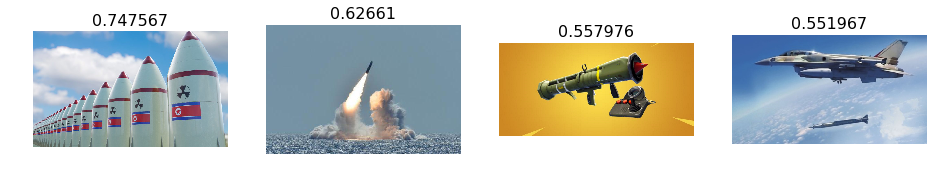

In [56]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect missile")

In [58]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect rockets")

Most incorrect rockets


Most uncertain predictions


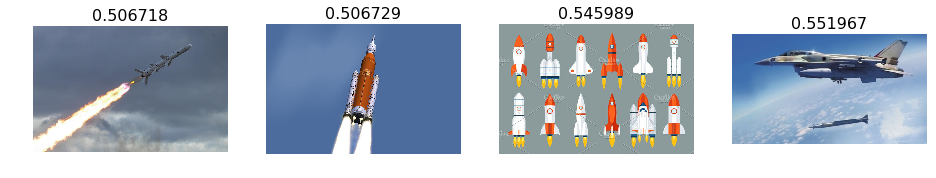

In [59]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")

## Learning Rate 


We create a new model to be able to set a learning rate

In [13]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [14]:
lrf = learn.lr_find()

A Jupyter Widget

epoch      trn_loss   val_loss   accuracy        
    0      1.040797   0.427565   0.8       



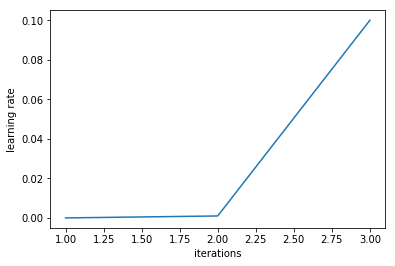

In [27]:
learn.sched.plot_lr()

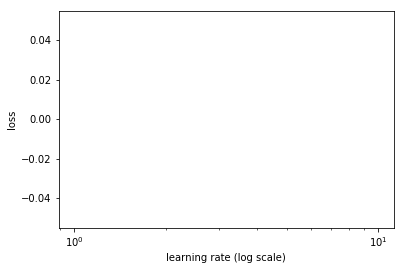

In [28]:
learn.sched.plot()

### Data Augmentation

We need to create new images by transforming them (horizontal flipping etc)
 aug_tfms (augmentation transforms) helps us with image transformations

In [29]:
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [31]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]           

In [32]:
ims = np.stack([get_augs() for i in range(6)])

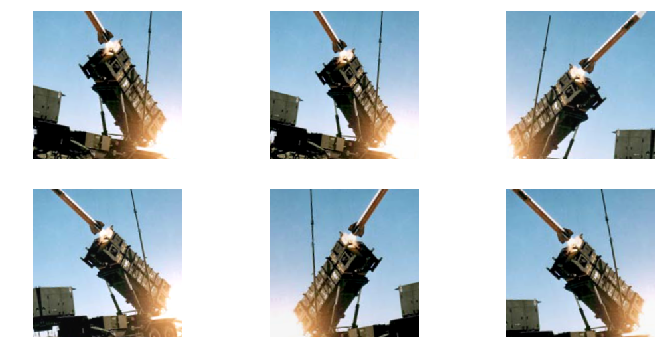

In [33]:
plots(ims, rows=2)

now we can make a new data object that includes the augmentation 

In [34]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [35]:
learn.fit(1e-2,1)

A Jupyter Widget

epoch      trn_loss   val_loss   accuracy       
    0      1.065086   1.000328   0.485714  



[array([ 1.00033]), 0.48571428656578064]

In [36]:
learn.precompute=False

In [37]:
learn.fit(1e-2, 3, cycle_len=1)

A Jupyter Widget

epoch      trn_loss   val_loss   accuracy                
    0      0.824267   0.684392   0.628571  
    1      0.762927   0.459463   0.8                     
    2      0.698584   0.335874   0.857143                



[array([ 0.33587]), 0.8571428656578064]

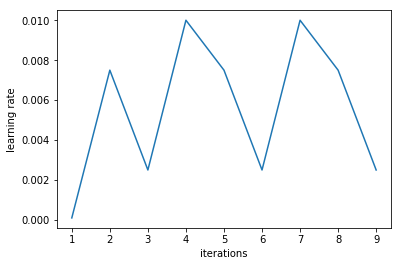

In [38]:
learn.sched.plot_lr()

In [39]:
learn.save('224_lastlayer')

In [40]:
learn.load('224_lastlayer')

Now we want to unfreeze the other layers.

In [41]:
learn.unfreeze()

use of differential learning rates

In [42]:
lr=np.array([1e-4,1e-3,1e-2])

In [43]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

A Jupyter Widget

epoch      trn_loss   val_loss   accuracy                
    0      0.694201   0.351443   0.885714  
    1      0.613907   0.332049   0.885714                
    2      0.587301   0.321865   0.857143                
    3      0.561969   0.252961   0.857143                
    4      0.519807   0.201542   0.914286                
    5      0.489033   0.177808   0.942857                
    6      0.453366   0.176971   0.942857                



[array([ 0.17697]), 0.94285714626312256]

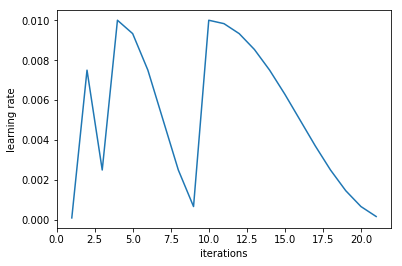

In [44]:
learn.sched.plot_lr()

this is the learning rate of the final layers of the model

In [46]:
learn.save('224_all')

In [47]:
learn.save('224_all')

Test Time Augmentation (TTA) - makes predictions on images in validation set but also on number of randomly augmented versions of them too

In [48]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

In [49]:
accuracy_np(probs, y)

0.97142857142857142

## Analyze the results

#### Confusion matrtix

In [50]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

In [51]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[17  0]
 [ 1 17]]


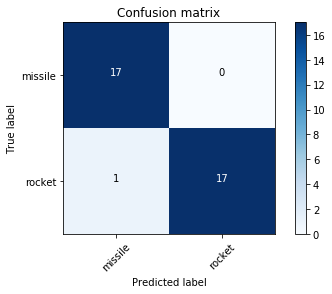

In [52]:
plot_confusion_matrix(cm, data.classes)

In [68]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect missiles")

Most incorrect missiles


Most incorrect rockets


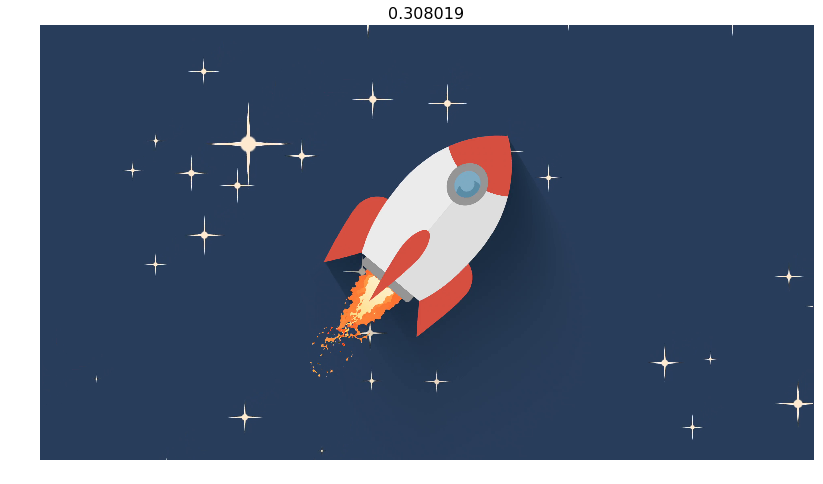

In [69]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect rockets")
